In [1]:
## Preliminary

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV

!pip install mitosheet 
import mitosheet 

!pip install xgboost
import xgboost

%config InlineBackend.figure_format = "svg"

In [3]:
df = pd.read_csv('../datasets/train.csv')

In [4]:
# Remove irrelevant columns

In [5]:
# Deleted columns property_id
df.drop(['property_id'], axis=1, inplace=True)

# Deleted columns property_name
df.drop(['property_name'], axis=1, inplace=True)

# Deleted columns property_summary
df.drop(['property_summary'], axis=1, inplace=True)

# Deleted columns property_space
df.drop(['property_space'], axis=1, inplace=True)

# Deleted columns property_desc
df.drop(['property_desc'], axis=1, inplace=True)

# Deleted columns property_neighborhood
df.drop(['property_neighborhood'], axis=1, inplace=True)

# Deleted columns property_notes
df.drop(['property_notes'], axis=1, inplace=True)

# Deleted columns property_transit
df.drop(['property_transit'], axis=1, inplace=True)

# Deleted columns property_access
df.drop(['property_access'], axis=1, inplace=True)

# Deleted columns property_interaction
df.drop(['property_interaction'], axis=1, inplace=True)

# Deleted columns property_rules
df.drop(['property_rules'], axis=1, inplace=True)

# Deleted columns property_sqfeet
df.drop(['property_sqfeet'], axis=1, inplace=True)

# Deleted columns property_scraped_at
df.drop(['property_scraped_at'], axis=1, inplace=True)

# Deleted columns property_last_updated
df.drop(['property_last_updated'], axis=1, inplace=True)

# Deleted columns host_id
df.drop(['host_id'], axis=1, inplace=True)

# Deleted columns host_location
df.drop(['host_location'], axis=1, inplace=True)

# Deleted columns host_about
df.drop(['host_about'], axis=1, inplace=True)

# Deleted columns host_nr_listings_total
df.drop(['host_nr_listings_total'], axis=1, inplace=True)

# Deleted columns host_verified
df.drop(['host_verified'], axis=1, inplace=True)

# Deleted columns booking_max_nights
df.drop(['booking_max_nights'], axis=1, inplace=True)

# Deleted columns reviews_first
df.drop(['reviews_first'], axis=1, inplace=True)

# Deleted columns reviews_last
df.drop(['reviews_last'], axis=1, inplace=True)

In [6]:
# Transform target to logarithm (target)
df['target'] = np.log(df['target'])

In [7]:
# Remove target outliers
Q1_target = df['target'].quantile(0.25)
Q3_target = df['target'].quantile(0.75)
IQR_target = Q3_target - Q1_target

lower_bound_target = Q1_target - 1.5 * IQR_target
upper_bound_target = Q3_target + 1.5 * IQR_target

df = df[(df['target'] >= lower_bound_target) & (df['target'] <= upper_bound_target)]

In [8]:
# Check for missing values
df['booking_availability_30'].isna().sum()

0

In [9]:
df['booking_availability_60'].isna().sum()

0

In [10]:
df['booking_availability_90'].isna().sum()

0

In [11]:
df['booking_availability_365'].isna().sum()

0

In [12]:
# Test multicollinearity
corr_matrix = df[['booking_availability_30', 'booking_availability_60', 'booking_availability_90', 'booking_availability_365', 'target']].corr()
corr_matrix = corr_matrix.rename(columns={'booking_availability_30': '30',
                                          'booking_availability_60': '60',
                                          'booking_availability_90': '90',
                                          'booking_availability_365': '365'})
corr_matrix = corr_matrix.rename(index={'booking_availability_30': '30',
                                         'booking_availability_60': '60',
                                         'booking_availability_90': '90',
                                         'booking_availability_365': '365',
                                         'target': 'target'})
print(corr_matrix)

              30        60        90       365    target
30      1.000000  0.938986  0.870734  0.557834 -0.015527
60      0.938986  1.000000  0.965422  0.626798 -0.011356
90      0.870734  0.965422  1.000000  0.673065 -0.009365
365     0.557834  0.626798  0.673065  1.000000  0.002767
target -0.015527 -0.011356 -0.009365  0.002767  1.000000


In [13]:
# Check significance of correlation with target
from scipy.stats import pearsonr

cols = ['booking_availability_30', 'booking_availability_60', 'booking_availability_90', 'booking_availability_365', 'target']
n_cols = len(cols)
corr_matrix = np.zeros((n_cols, n_cols))
p_values = np.zeros((n_cols, n_cols))

for i in range(n_cols):
    for j in range(n_cols):
        corr, p_val = pearsonr(df[cols[i]], df[cols[j]])
        corr_matrix[i, j] = corr
        p_values[i, j] = p_val

corr_df = pd.DataFrame(corr_matrix, columns=cols, index=cols)
p_df = pd.DataFrame(p_values, columns=cols, index=cols)

print(p_df)

                          booking_availability_30  booking_availability_60  \
booking_availability_30                  0.000000                 0.000000   
booking_availability_60                  0.000000                 0.000000   
booking_availability_90                  0.000000                 0.000000   
booking_availability_365                 0.000000                 0.000000   
target                                   0.214985                 0.364489   

                          booking_availability_90  booking_availability_365  \
booking_availability_30                  0.000000                   0.00000   
booking_availability_60                  0.000000                   0.00000   
booking_availability_90                  0.000000                   0.00000   
booking_availability_365                 0.000000                   0.00000   
target                                   0.454576                   0.82515   

                            target  
booking_availabilit

In [14]:
# For that reason, we will only continue with booking_availabilty_30
df.drop(['booking_availability_60'], axis=1, inplace=True)
df.drop(['booking_availability_90'], axis=1, inplace=True)
df.drop(['booking_availability_365'], axis=1, inplace=True)

In [15]:
correlation30 = df['booking_availability_30'].corr(df['target'])
print(correlation30)

-0.015527257620869784


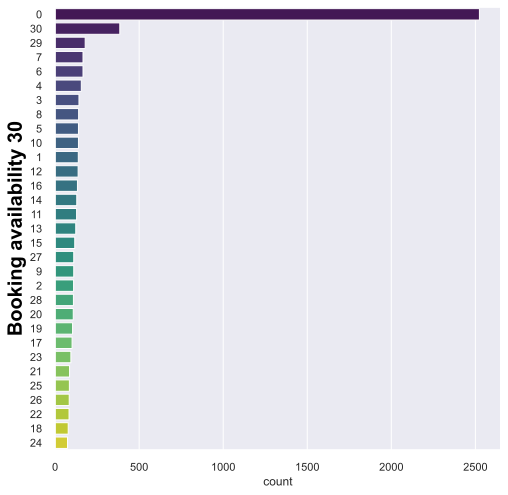

In [16]:
sns.set(style='darkgrid')
plt.figure(figsize=(8,8))
sns.countplot(y = 'booking_availability_30',data = df,order = df['booking_availability_30'].value_counts().index,palette = "viridis")
plt.ylabel('Booking availability 30',fontsize = 20, weight = 'bold',color='black')
#plt.axes().set(facecolor = "White")
plt.show()

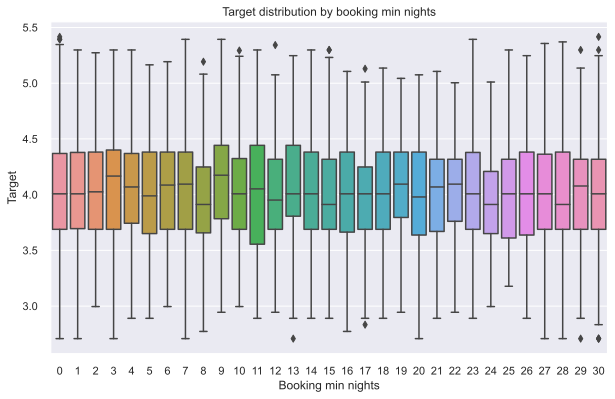

In [17]:
# Generate the boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='booking_availability_30', y='target', data=df)
ax.set_title('Target distribution by booking min nights')
ax.set_xlabel('Booking min nights')
ax.set_ylabel('Target')
plt.show()

In [18]:
# Generate the statistical description
df.groupby('booking_availability_30')['target'].describe()

,count,mean,std,min,25%,50%,75%,max
booking_availability_30,,,,,,,,
0,2524.0,4.020818,0.522824,2.708050,3.688879,4.007333,4.369448,5.416100
1,138.0,4.044772,0.475796,2.708050,3.695053,4.007333,4.378882,5.298317
2,110.0,4.037407,0.520162,2.995732,3.688879,4.025192,4.382027,5.273000
3,142.0,4.066691,0.519217,2.708050,3.688879,4.166635,4.400546,5.298317
4,156.0,4.040539,0.495138,2.890372,3.743120,4.068990,4.369448,5.298317
5,139.0,3.988376,0.517098,2.890372,3.650574,3.988984,4.382027,5.164786
6,166.0,4.049827,0.522207,2.995732,3.688879,4.085941,4.382027,5.192957
7,166.0,4.067357,0.544242,2.708050,3.688879,4.094345,4.382027,5.393628
8,140.0,3.952342,0.517739,2.772589,3.657068,3.912023,4.248495,5.192957


In [19]:
# Because of the reasons highlighted in this EDA, we have decided to NOT remove booking_availability_30
# as an attribute from our training set.